In [1]:
import warnings
warnings.filterwarnings('ignore')

# AICSImageIO
### Microscopy Image IO in Pure Python

<br>

Dask Summit 2021, Life Sciences Workshop

Jackson Maxfield Brown

## In This Talk

1. What is AICSImageIO
2. Issues with Image Processing
3. What's New and Where We Are Going

## AICSImageIO At a High Level

AICSImageIO aims to provide a **consistent intuitive API for reading in or out-of-memory image pixel data and metadata** ...

We don't try to do any fancy processing - instead we are solely concerned about pure Python Microscopy file IO and _"good"_ metadata attachment and utilization.

### Dimensions -- Order and Shape

Our object model mirrors the Open Microscopy Environment (OME) metadata model wherever possible.

That means, a consistent dimension ordering and shape -- defined by metadata.

In [2]:
from dask_image.imread import imread
da_img = imread("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")
da_img

dask.array<_map_read_frame, shape=(666, 1024, 1024), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

In [3]:
from aicsimageio import AICSImage
aics_img = AICSImage("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")
aics_img.dask_data

dask.array<transpose, shape=(1, 9, 74, 1024, 1024), dtype=uint16, chunksize=(1, 1, 74, 1024, 1024), chunktype=numpy.ndarray>

It also means that our image container is more than simply the array of voxels.

We provide easy access to dimension information, common pieces of metadata (or full access to metadata), writing / conversion, and more...

In [4]:
aics_img.dims

<Dimensions [T: 1, C: 9, Z: 74, Y: 1024, X: 1024]>

In [5]:
aics_img.channel_names

['DRAQ5',
 'EGFP',
 'Hoechst 33258',
 'TL Brightfield',
 'SEG_STRUCT',
 'SEG_Memb',
 'SEG_DNA',
 'CON_Memb',
 'CON_DNA']

In [6]:
aics_img.metadata

OME(
   experimenters=[<1 Experimenters>],
   images=[<1 Images>],
   instruments=[<1 Instruments>],
   uuid='urn:uuid:82cf0bcd-7e49-4cb1-b042-bd0aaa0b0590',
)

... and crucially we can read multi-scene!

In [7]:
# dask-image
imread("../../aicsimageio/tests/resources/s_3_t_1_c_3_z_5.ome.tiff").shape

(15, 325, 475)

In [8]:
# aicsimageio
many_scene = AICSImage("../../aicsimageio/tests/resources/s_3_t_1_c_3_z_5.ome.tiff")
many_scene.dims

<Dimensions [T: 1, C: 3, Z: 5, Y: 325, X: 475]>

In [9]:
many_scene.scenes

('Image:0', 'Image:1', 'Image:2')

In [10]:
many_scene.set_scene("Image:1")

## Issues with Image Processing

As files become larger and larger, object models that _encourage_ metadata utilization are critical to reducing processing times.

In [11]:
import dask.array as da

def norm_and_proj_channel(data):
    # Get percentile norm by values
    min_px_val, max_px_val = da.percentile(
        data.flatten(),
        [50.0, 99.8],
    ).compute()

    # Norm
    normed = (data - min_px_val) / (max_px_val - min_px_val)

    # Clip any values outside of 0 and 1
    clipped = da.clip(normed, 0, 1)

    # Scale them between 0 and 255
    scaled = clipped * 255

    # Create max project
    return scaled.max(axis=0)

In [12]:
from matplotlib.pyplot import imshow, set_cmap
set_cmap("inferno")

<Figure size 432x288 with 0 Axes>

## Time Comparison with Naive Reshape

In [13]:
da_img = imread("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")
da_img = da_img.reshape(74, 9, 1024, 1024)

aics_img = AICSImage("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")

Normalize a specific channel and generate a max projection.

Notice, the obvious time difference, but also the API difference.

Metadata utilization throughout!

In [14]:
%%timeit
da_channel = da_img[:, 2]
da_proj = norm_and_proj_channel(da_channel).compute()

1min 35s ± 1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
aics_channel = aics_img.get_image_dask_data(
    "ZYX",
    C=aics_img.channel_names.index("Hoechst 33258")
)
aics_proj = norm_and_proj_channel(aics_channel).compute()

1.79 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


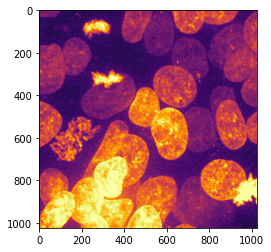

In [17]:
aics_channel = aics_img.get_image_dask_data(
    "ZYX",
    C=aics_img.channel_names.index("Hoechst 33258")
)
aics_proj = norm_and_proj_channel(aics_channel).compute()
imshow(aics_proj)

## What About Rechunking

We already had to reshape, rechunking is just yet another step.

Our job is to make it easier, and _faster_, for the scientist to get their work done.

## Chunking by Dimension

`AICSImage` defaults to chunking with the ZYX dimensions, but this is simply a parameter:

In [18]:
AICSImage(
    "../../aicsimageio/tests/resources/image_stack_tpzc_50tp_2p_5z_3c_512k_1_MMStack_2-Pos000_000.ome.tif",
    chunk_dims="TYX",
).dask_data

[WARNING: ome_tiff_reader: 137 2021-05-10 23:35:11,999] Multi-image (or scene) OME-TIFFs created by MicroManager have limited support for scene API. It is recommended to use independent AICSImage or Reader objects for each file instead of the `set_scene` API. Track progress on support here: https://github.com/AllenCellModeling/aicsimageio/issues/196


dask.array<transpose, shape=(50, 3, 5, 256, 256), dtype=uint16, chunksize=(50, 1, 1, 256, 256), chunktype=numpy.ndarray>

## What's New and Where We Are Going

4.0 is just around the corner and it's the perfect time to get involved!

(In fact, it may be out by the time you watch this video)

### New Features
✅ Mosaic Tile Stitching

In [19]:
tiled = AICSImage("../../aicsimageio/tests/resources/tiled.lif")
tiled.dask_data

,Array,Chunk
Bytes,164.41 MiB,256.00 kiB
Shape,"(1, 4, 1, 5622, 7666)","(1, 1, 1, 512, 512)"
Count,8476 Tasks,660 Chunks
Type,uint8,numpy.ndarray


### New Features
✅ XArray Adopted

In [20]:
tiled.xarray_dask_data.loc[:, :, :, :5000, :5000]

<xarray.DataArray 'transpose-ab2ad37e6fb21bdae1a52b30678c61f2' (T: 1, C: 4, Z: 1, Y: 1004, X: 1004)>
dask.array<getitem, shape=(1, 4, 1, 1004, 1004), dtype=uint8, chunksize=(1, 1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * C        (C) <U5 'Gray' 'Red' 'Green' 'Cyan'
  * Y        (Y) float64 0.0 4.985 9.969 14.95 ... 4.99e+03 4.995e+03 5e+03
  * X        (X) float64 0.0 4.985 9.969 14.95 ... 4.99e+03 4.995e+03 5e+03
Dimensions without coordinates: T, Z
Attributes:
    unprocessed:  <Element 'LMSDataContainerHeader' at 0x7f4200094220>

### New Features
✅ FSSpec Adopted

In [21]:
AICSImage("s3://aics-modeling-packages-test-resources/aicsimageio/test_resources/resources/example.jpg").dims

[INFO: credentials:1222 2021-05-10 23:35:14,306] Found credentials in shared credentials file: ~/.aws/credentials


<Dimensions [T: 1, C: 1, Z: 1, Y: 452, X: 400, S: 3]>

### New Features
✅ Better Writers<br>
✅ Dedicated RGB / BGR Support<br>
✅ Optional Reader Installation<br>

... And more!

### Upcoming

⏭️ `OME.Zarr` Support

⏭️ On the Fly Metadata Translation (CZI-to-OME XSLT)

and of course...

⏭️ Updating the `napari-aicsimageio` plugin

## Install

`pip install aicsimageio`

## Links

#### AICSImageIO
Repo: [github.com/AllenCellModeling/aicsimageio](https://github.com/AllenCellModeling/aicsimageio)<br>
Docs: [AllenCellModeling.github.io/aicsimageio](https://AllenCellModeling.github.io/aicsimageio)

#### Me
GitHub: [github.com/JacksonMaxfield](https://github.com/JacksonMaxfield)<br>
Twitter: [twitter.com/jmaxfieldbrown](https://twitter.com/jmaxfieldbrown)